In [ ]:
!pip install natsort

In [ ]:
import sklearn
import tensorflow as tf
import scipy.io
import numpy as np
import os
import natsort

In [ ]:
!ls ..

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATAPATH = '/content/drive/Shareddrives/BCI_Project/session2/'

In [ ]:
files = natsort.natsorted(os.listdir(DATAPATH))

In [ ]:
erp_data = [f for f in files if "ERP" in f]
mi_data = [f for f in files if "MI" in f]
ssvep_data = [f for f in files if "SSVEP" in f]
#################################################
train_data = [(erp_data[i], mi_data[i], ssvep_data[i]) for i in range(len(erp_data)) if "train" in erp_data[i]]
test_data = [(erp_data[i], mi_data[i], ssvep_data[i]) for i in range(len(erp_data)) if "test" in erp_data[i]]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def get_data_splits(files, mode):
  full_erp_x = []
  full_mi_x = []
  full_ssvep_x = []

  full_erp_y = []
  full_mi_y = []
  full_ssvep_y = []

  for data in files:
    erp_file, mi_file, ssvep_file = data

    erp_mat = scipy.io.loadmat(DATAPATH + erp_file)
    erp_x = erp_mat['save_erp_' + mode]['x'][0][0].T
    erp_y = erp_mat['save_erp_' + mode]['y'][0][0].T
    full_erp_x.append(erp_x)
    full_erp_y.append(erp_y)

    mi_mat = scipy.io.loadmat(DATAPATH + mi_file)
    mi_x = mi_mat['save_mi_' + mode]['x'][0][0].T
    mi_y = mi_mat['save_mi_' + mode]['y'][0][0].T
    full_mi_x.append(mi_x)
    full_mi_y.append(mi_y)

    ssvep_mat = scipy.io.loadmat(DATAPATH + ssvep_file)
    ssvep_x = ssvep_mat['save_ssvep_' + mode]['x'][0][0].T
    ssvep_y = ssvep_mat['save_ssvep_' + mode]['y'][0][0].T
    full_ssvep_x.append(ssvep_x)
    full_ssvep_y.append(ssvep_y)

  full_erp_x = np.concatenate(full_erp_x, axis=0)
  full_erp_y = np.concatenate(full_erp_y, axis=0)
  full_erp_scaled = StandardScaler().fit_transform(full_erp_x)
  pca = PCA(n_components=20)
  full_erp_x = pca.fit_transform(full_erp_scaled)

  full_mi_x = np.concatenate(full_mi_x, axis=0)
  full_mi_y = np.concatenate(full_mi_y, axis=0)
  full_mi_x = StandardScaler().fit_transform(full_mi_x)

  full_ssvep_x = np.concatenate(full_ssvep_x, axis=0)
  full_ssvep_y = np.concatenate(full_ssvep_y, axis=0)
  full_ssvep_x = StandardScaler().fit_transform(full_ssvep_x)
  return [(full_erp_x, full_erp_y), (full_mi_x, full_mi_y), (full_ssvep_x, full_ssvep_y)]

(erp_tr_x, erp_tr_y), (mi_tr_x, mi_tr_y), (ssvep_tr_x, ssvep_tr_y) = get_data_splits(train_data, 'tr')
(erp_te_x, erp_te_y), (mi_te_x, mi_te_y), (ssvep_te_x, ssvep_te_y) = get_data_splits(test_data, 'te')

In [ ]:
np.random.uniform(low=0, high=2, size=((5, 5)))

array([[1.55619646, 1.81004705, 1.66853387, 0.15097692, 1.77206236],
       [0.9800789 , 0.8548925 , 0.693311  , 1.5431539 , 0.71830482],
       [0.50629596, 1.01154298, 1.57987478, 0.34431628, 0.96691518],
       [0.93424849, 0.10118171, 1.1386389 , 1.70995518, 1.03294881],
       [1.11591738, 1.92628184, 1.13482986, 1.35396128, 0.72971602]])

In [ ]:
def padding(x, y, paradigm, target_dim_x=32, target_dim_y=8):
  if paradigm == "ERP":
    padding_x = np.zeros((x.shape[0], target_dim_x - x.shape[1]))
    padding_y = np.zeros((y.shape[0], target_dim_y - y.shape[1]))
    padded_x = np.concatenate([x, padding_x], axis=1)
    padded_y = np.concatenate([y, padding_y], axis=1)
  elif paradigm == "MI":
    padding_x_l = np.zeros((x.shape[0], 20))
    padding_x_r = np.zeros((x.shape[0], 4))
    padding_y_u = np.zeros((y.shape[0], 2))
    padding_y_d = np.zeros((y.shape[0], 4))
    padded_x = np.concatenate([padding_x_l, x, padding_x_r], axis=1)
    padded_y = np.concatenate([padding_y_u, y, padding_y_d], axis=1)
  elif paradigm == "SSVEP":
    padding_x = np.zeros((x.shape[0], target_dim_x - x.shape[1]))
    padding_y = np.zeros((y.shape[0], target_dim_y - y.shape[1]))
    padded_x = np.concatenate([padding_x, x], axis=1)
    padded_y = np.concatenate([padding_y, y], axis=1)
  else:
    print("Unknown paradigm")
    return None
  return padded_x, padded_y

In [ ]:
# Training data
padded_erp_x_tr, padded_erp_y_tr = padding(erp_tr_x, erp_tr_y, "ERP")
padded_mi_x_tr, padded_mi_y_tr = padding(mi_tr_x, mi_tr_y, "MI")
padded_ssvep_x_tr, padded_ssvep_y_tr = padding(ssvep_tr_x, ssvep_tr_y, "SSVEP")

# Testing data
padded_erp_x_te, padded_erp_y_te = padding(erp_te_x, erp_te_y, "ERP")
padded_mi_x_te, padded_mi_y_te = padding(mi_te_x, mi_te_y, "MI")
padded_ssvep_x_te, padded_ssvep_y_te = padding(ssvep_te_x, ssvep_te_y, "SSVEP")

In [ ]:
X_tr = np.concatenate([padded_erp_x_tr, padded_mi_x_tr, padded_ssvep_x_tr], axis=0)
Y_tr = np.concatenate([padded_erp_y_tr, padded_mi_y_tr, padded_ssvep_y_tr], axis=0)
Y_tr_idx = [np.argmax(y) for y in Y_tr]

X_te = np.concatenate([padded_erp_x_te, padded_mi_x_te, padded_ssvep_x_te], axis=0)
Y_te = np.concatenate([padded_erp_y_te, padded_mi_y_te, padded_ssvep_y_te], axis=0)
Y_te_idx = [np.argmax(y) for y in Y_te]

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.svm import SVC
from numpy import arange
from sklearn.neighbors import KNeighborsClassifier

cv = KFold(n_splits=10, random_state=1, shuffle=True)

NCC_params = {'metric' : ['euclidean', 'manhattan'],
              'shrink_threshold' : arange(0, 1.0, 0.1)}

ncc_grid = GridSearchCV(NearestCentroid(), NCC_params, scoring='accuracy',
                        cv=cv)

LDA_params = {'solver' : ['lsqr', 'eigen'],
              'shrinkage' : arange(0, 1.0, 0.1)}

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), LDA_params,
                        scoring='accuracy', cv=cv)

SVC_params = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto']}
svc_grid = GridSearchCV(SVC(), SVC_params,
                        scoring='accuracy', cv=cv, n_jobs=4)

knn_params = {
    'n_neighbors' : [3, 5, 11, 19],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
                  KNeighborsClassifier(),
                  knn_params,
                  cv = cv, 
                  n_jobs = 4,
                  scoring = 'accuracy', 
                  )


In [ ]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

ncc_grid.fit(X_tr, Y_tr_idx) 
ncc_cf = ncc_grid.best_estimator_
print('NCC Score: ', round(accuracy_score(ncc_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

lda_grid.fit(X_tr, Y_tr_idx)
lda_cf = lda_grid.best_estimator_
print('LDA Score: ', round(accuracy_score(lda_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

svc_grid.fit(X_tr, Y_tr_idx)
svc_cf = svc_grid.best_estimator_
print('SVC Score: ', round(accuracy_score(svc_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

knn_grid.fit(X_tr, Y_tr_idx)
knn_cf = knn_grid.best_estimator_
print('KNN Score: ', round(accuracy_score(knn_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

NCC Score:  74.94%
LDA Score:  71.17%
KNN Score:  86.83%
Best params for KNN  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


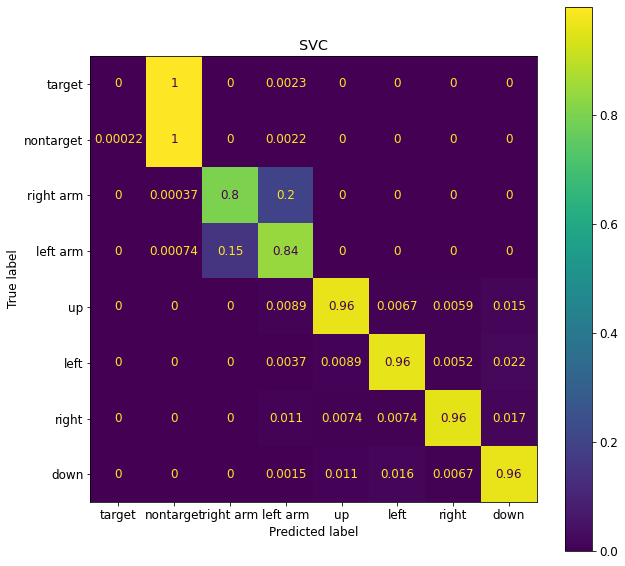

In [ ]:

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
labels = ["target", "nontarget", "right arm", "left arm", "up", "left", "right", "down"]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(figsize=(10, 10))
axs[0,0].set_title("LDA")
plot_confusion_matrix(lda_cf, X_te, Y_te_idx, normalize="true", ax=axs[0,0], display_labels=labels)
axs[0,1].set_title("NCC")
plot_confusion_matrix(ncc_cf, X_te, Y_te_idx, normalize="true", ax=axs[0,1], display_labels=labels)
axs[1,0].set_title("SVC")
plot_confusion_matrix(svc_cf, X_te, Y_te_idx, normalize="true", ax=axs[1,0], display_labels=labels)
axs[1,1].set_title("KNN")
plot_confusion_matrix(knn_cf, X_te, Y_te_idx, normalize="true", ax=axs[1,1], display_labels=labels)
